In [1]:
# gpu info
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX450 (UUID: GPU-f8138aab-5e62-432f-3a34-fa8e2d8584cf)


In [3]:
import ee
import numpy as np
import pandas as pd
from pprint import pprint
import rasterio
from rasterio.crs import CRS

import matplotlib.pyplot as plt
import seaborn as sns


import json
import sys
import glob
import os
import gc
from tqdm.auto import tqdm

import tensorflow as tf
import torch

In [4]:
# authenticate earthengine api
ee.Initialize()

RefreshError: ('invalid_grant: Token has been expired or revoked.', {'error': 'invalid_grant', 'error_description': 'Token has been expired or revoked.'})

In [4]:
# change cwd
cwd = '/content/G_drive/MyDrive/Colab Notebooks/Paper_3/Earth_Engine_codes/Step_1_UNET_predict_future_urbanization'
os.chdir(cwd)

In [5]:
# append path so to load custom modules
import sys
sys.path.append('./torch_modules')

# might need reload modules as the code changes
%load_ext autoreload
%autoreload 2

# load global variables
from Global_Variables import *
from helper_funcs import TF_to_npy,get_dataset

Parse TF records

In [ ]:
# copy tf-record from gdrive to colab
tf_path_gdrive = "/content/G_drive/MyDrive/urban_prj_torch_sample"
tf_sample_folder = 'TF_record_samples'
tf_path_colab =  '/content/TF_record'

tf_records = glob.glob(f"{tf_sample_folder}/pred*")

# copy samples to colab_drive to speed up the inference
if len(os.listdir(tf_path_colab)) > 0:
  print('TF-records alread copied!\n\n')
else:
  print('Copy TF-records to colab!\n\n')
  for record in tqdm(tf_records):
    !cp {record} {tf_path_colab}/


# converting TF-record to numpy
year_selecte = f"{proj_yr_selected[0]}_{proj_yr_selected[1]}"

tf_img_pattern = f'{tf_path_colab}/pred_*.gz'
tf_img_features = FEATURES_train[:-1]

buffered_shape = [KERNEL_SIZE+ KERNEL_BUFFER,KERNEL_SIZE + KERNEL_BUFFER]
tf_img_fe_dict = {k:tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) for k in  tf_img_features}

# get info from mixer
tf_img_json = f"{tf_path_colab}/pred_{year_selecte}-mixer.json"
jsonText = !cat {tf_img_json}
mixer = json.loads(jsonText.nlstr)
patches = mixer['totalPatches']
patch_per_row = mixer['patchesPerRow']
pprint(mixer)

# Create a dataset from the TFRecord file(s)
img_dataset = get_dataset(tf_img_pattern,tf_img_features,tf_img_fe_dict,mode = 'pred')

Copy TF-records to colab!




  0%|          | 0/404 [00:00<?, ?it/s]

{'patchDimensions': [512, 512],
 'patchesPerRow': 89,
 'projection': {'affine': {'doubleMatrix': [0.0002694945852358564,
                                            0.0,
                                            110.35399023530468,
                                            0.0,
                                            -0.0002694945852358564,
                                            42.61490926876075]},
                'crs': 'EPSG:4326'},
 'totalPatches': 8455}


Use the trained model to predict

In [ ]:
# setup device
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# load model
from UNET_model_aladin import UNET
m = UNET().to(dev)

# m = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=False).to(dev)

best_model = glob.glob('./Saved_models/best_model*')
best_model = sorted(best_model)[-1]

longest_trained_model = glob.glob('./Saved_models/progress_model*')
longest_trained_model = sorted(longest_trained_model)[-1]

# load model weights
m.load_state_dict(torch.load(best_model,map_location=torch.device(dev)))
m.eval()

In [ ]:
# sort out the 2D-arrangement of pathes according to their index
patch_idx_matrix = np.arange(patches).reshape(-1,patch_per_row)

# split each row into several segments to avoide GPU memory explosion
row_split_num = 20

In [ ]:
# inference
for idx,record in enumerate(tqdm(img_dataset,total=patches),1):

  # get the tensor
  tensor = torch.FloatTensor(record.numpy()).to(dev).unsqueeze(0)

  # judge if it is the first path in a row
  if idx%patch_per_row == 1:
    patch_list = [tensor]
  elif idx%patch_per_row != 0:
    patch_list.append(tensor)
  else:
    patch_list.append(tensor)

    # split each row into several segments to avoide GPU memory exposion
    for row_idx,split_list in enumerate(np.array_split(range(patch_per_row),row_split_num)):
      
      # get the segmentation
      start,end = split_list[0],split_list[-1]+1
      segment = patch_list[start:end]
      segment = torch.cat(segment,0)

      # performe inference
      inference = m(segment)

      # multiply the inference by 10000, convert it to int to reduce memory use
      inference = (inference * 10000).to(torch.int16)

      # cut off buffers
      cut_size = int(KERNEL_BUFFER/2)
      inference = inference[:,
                :,
                cut_size:cut_size+KERNEL_SIZE,
                cut_size:cut_size+KERNEL_SIZE]

      # transpose the tenser, think about why it's a (2,0,1,3) transformation?
      # 1) the first dim should be along with img width, which is the dim-2  in the original tensor
      # 2) the sencond dim should be along with img patch index, which is the dim-0 dim in the original tensor
      # 3) because the img only has one channel, so it's doesn't matter which dim of these comes next
      inference = torch.permute(inference,(2,0,1,3)).reshape((KERNEL_SIZE,-1))

      # copy tensor to cup np array
      inference = inference.detach().cpu().numpy().astype(np.int16)

      # save prediction to disk to save memory
      if not os.path.exists('/content/Sample_npy'): 
        os.makedirs('/content/Sample_npy',exist_ok=True)
      np.save(f'/content/Sample_npy/pred_{year_selecte}_{idx:05}_{row_idx:03}.npy',inference)

  0%|          | 0/8455 [00:00<?, ?it/s]

### concat all pred-array into one arrary

In [ ]:
# fetch all np_arr files
arr_path_list = sorted(glob.glob('/content/Sample_npy/*'))
arr_path_list_seg = [arr_path_list[i:i+row_split_num] for i in range(0,len(arr_path_list),row_split_num)]

In [ ]:
# read all arrary
array_list = []

for idx,arr_list in enumerate(tqdm(arr_path_list_seg)):

  # concate arr of each img_row
  arr_in_row = []
  for f_idx,f in enumerate(arr_list):
    arr = np.load(f,allow_pickle=True)
    arr_in_row.append(arr)
    
  arr_row = np.concatenate(arr_in_row,1)
  # put each img_row_arr to list
  array_list.append(arr_row)

  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
# concat all arr_row into the complete img array
img_arr = np.concatenate(array_list,0)
img_arr.shape

del array_list
import gc
gc.collect()

1413

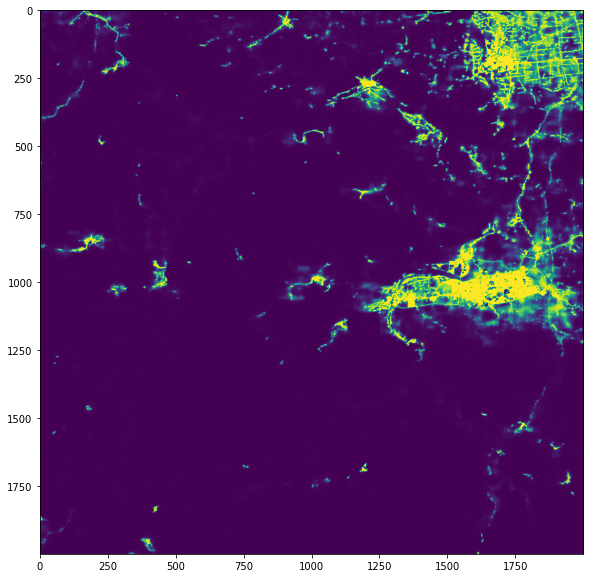

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_arr[40560:42560,20560:22560])

### save arry to tif

In [ ]:
# nudge the affine origin by 1/2 KERNEL_BUFFER, because which was shifted uopon exported as TF-record
affine_origin = mixer['projection']['affine']['doubleMatrix'].copy()
affine_shifted = affine_origin.copy()

pix_size = affine_shifted[0]

affine_shifted[2] = affine_shifted[2] + KERNEL_BUFFER/2*pix_size
affine_shifted[5] = affine_shifted[5] - KERNEL_BUFFER/2*pix_size
affine_shifted

[0.0002694945852358564,
 0.0,
 110.37123788875978,
 0.0,
 -0.0002694945852358564,
 42.597661615305654]

In [ ]:
Tif_save_path = './Simulated_Tif'
Tif_save_name = f'trainsition_potential_{proj_yr_selected[0]}_{proj_yr_selected[1]}.tif'

with rasterio.open(fp=f'{Tif_save_path}/{Tif_save_name}',
          mode='w',
          driver='GTiff',
          width =img_arr.shape[1],
          height = img_arr.shape[0],
          count = 1,
          crs = CRS.from_string(mixer['projection']['crs']),
          transform=rasterio.Affine(*affine_origin),
          dtype='int16',
          compress='lzw') as dst:
          
  dst.write(np.expand_dims(img_arr,0))

### Copy unet_tif to gcloud, then upload it to GEE_asset


In [ ]:
# authenticate to GCP
from google.colab import auth
auth.authenticate_user()

In [ ]:
# upload tifs from G_Drive to GCP
Tif_save_path = './Simulated_Tif'
Tif_save_name = f'trainsition_potential_{proj_yr_selected[0]}_{proj_yr_selected[1]}'

!gsutil -m cp '{Tif_save_path}'/'{Tif_save_name}'.tif gs://paper_3

In [ ]:
# upload to GEE
! earthengine upload image --asset_id=users/wangjinzhulala/Paper_3/06_Urban_projection/{Tif_save_name} gs://paper_3/{Tif_save_name}.tif

Started upload task with ID: SZ6YPQBDXLLEX6RI2PLIF373
